In [1]:
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
import fasttext
import fasttext.util
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torchmetrics

C:\Users\Omer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Omer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
ft = fasttext.load_model('cc.en.300.bin')

In [3]:
df=pd.read_table("dataset/train.txt",delimiter=";",header=None,)
df.columns=['Text','Label']
df_test=pd.read_table("dataset/test.txt",delimiter=";",header=None,)
df_test.columns=['Text','Label']
df_val=pd.read_table("dataset/val.txt",delimiter=";",header=None,)
df_val.columns=['Text','Label']

In [4]:
df.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df['Label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Label, dtype: int64

In [6]:
df.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
embed_size=ft.get_word_vector('hello').shape[0]

In [8]:
def count_words(sentence):
    words = sentence.lower().split()
    return len(words)

In [9]:
df['Text_length'] = df['Text'].apply(count_words)
df_test['Text_length'] = df_test['Text'].apply(count_words)
df_val['Text_length'] = df_val['Text'].apply(count_words)

In [10]:
df.min()

Text           a boyfriend with whom i split up with came ove...
Label                                                      anger
Text_length                                                    2
dtype: object

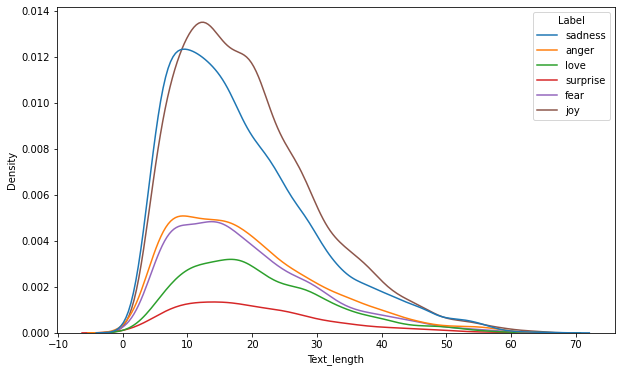

In [11]:
fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=df['Text_length'],
    hue=df['Label']
)
plt.show()

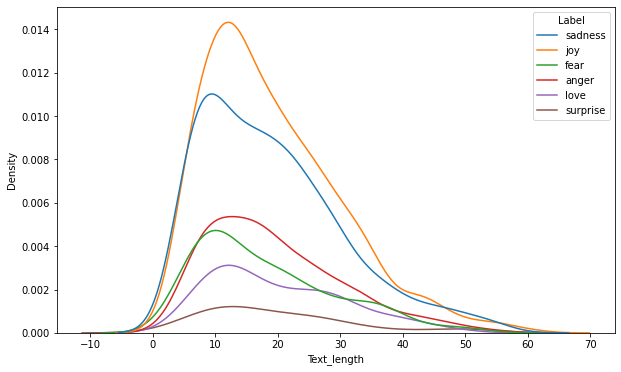

In [12]:
fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=df_test['Text_length'],
    hue=df_test['Label']
)
plt.show()

In [13]:
df[['Text_length']].describe()

,Text_length
count,16000.000000
mean,19.166313
std,10.986905
min,2.000000
25%,11.000000
50%,17.000000
75%,25.000000
max,66.000000


In [14]:
df = df[df.Text_length <= 30]
df_test = df_test[df_test.Text_length <= 30]
df_val = df_val[df_val.Text_length <= 30]

In [15]:
print('test:')
print(df_test.count())
print('val:')
print(df_val.count())

test:
Text           1690
Label          1690
Text_length    1690
dtype: int64
val:
Text           1715
Label          1715
Text_length    1715
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13601 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         13601 non-null  object
 1   Label        13601 non-null  object
 2   Text_length  13601 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 425.0+ KB


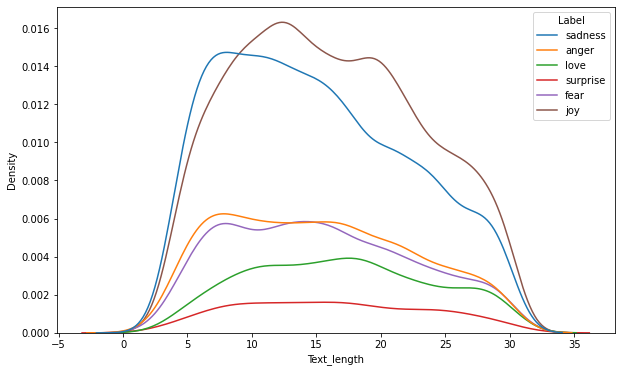

In [17]:
fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=df['Text_length'],
    hue=df['Label']
)
plt.show()

In [18]:
df['Label'].value_counts()

joy         4556
sadness     4026
anger       1802
fear        1658
love        1079
surprise     480
Name: Label, dtype: int64

In [19]:
joy=df[df['Label']=='joy'];
sadness=df[df['Label']=='sadness'];
anger=df[df['Label']=='anger'];
fear=df[df['Label']=='fear'];
love=df[df['Label']=='love'];
surprise=df[df['Label']=='surprise'];

joy=joy.sample(2500);
sadness=sadness.sample(2500)

df=pd.concat([joy,sadness,anger,fear,love,surprise])

In [20]:
df['Label'].value_counts()

joy         2500
sadness     2500
anger       1802
fear        1658
love        1079
surprise     480
Name: Label, dtype: int64

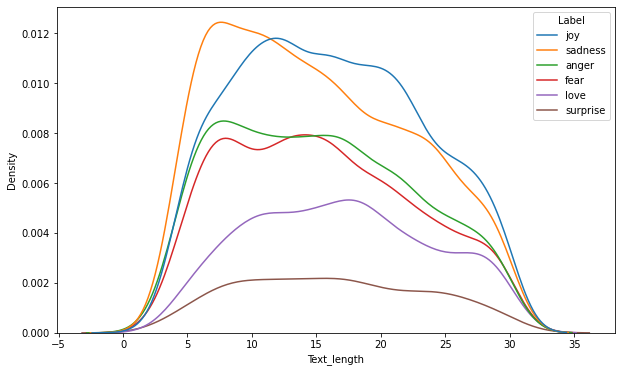

In [21]:
fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=df['Text_length'],
    hue=df['Label']
)
plt.show()

In [22]:
df[df['Text_length']==30].sample(1)

,Text,Label,Text_length
15239,i feel angry because instead of asking how am ...,anger,30


In [23]:
y_train = pd.get_dummies(df.Label, prefix='Label')

In [24]:
# y_train=df['Label'].map({'anger':0,'fear':1,'joy':2,'love':3,'sadness':4,'surprise':5 })

In [24]:
y_train.head()

,Label_anger,Label_fear,Label_joy,Label_love,Label_sadness,Label_surprise
12830,0,0,1,0,0,0
4108,0,0,1,0,0,0
1015,0,0,1,0,0,0
343,0,0,1,0,0,0
2969,0,0,1,0,0,0


In [25]:
y_test = pd.get_dummies(df_test.Label, prefix='Label')
y_val = pd.get_dummies(df_val.Label, prefix='Label')

In [27]:
# y_test = df_test['Label'].map({'anger':0,'fear':1,'joy':2,'love':3,'sadness':4,'surprise':5 })
# y_val = df_val['Label'].map({'anger':0,'fear':1,'joy':2,'love':3,'sadness':4,'surprise':5 })

In [26]:
y_train.describe()

,Label_anger,Label_fear,Label_joy,Label_love,Label_sadness,Label_surprise
count,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000
mean,0.179858,0.165486,0.249526,0.107695,0.249526,0.047909
std,0.384089,0.371637,0.432760,0.310011,0.432760,0.213584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
def sentence_to_numbers(sentence): #embed sentence, and zero pad before sentence
    words = sentence.lower().split()
    embedded_words = np.zeros([30,300]) #text length 30, embed vector 300
    j=29-len(words) #
    for w in words:
        embedded_words[j] = ft.get_word_vector(w)
        j+=1
    return embedded_words

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10019 entries, 12830 to 15970
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         10019 non-null  object
 1   Label        10019 non-null  object
 2   Text_length  10019 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 313.1+ KB


In [59]:
x_train = np.full([10019,30,embed_size], -1e9)
j=0
for sentence in df.Text:
    x_train[j] = sentence_to_numbers(sentence)
    j+=1

In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         1690 non-null   object
 1   Label        1690 non-null   object
 2   Text_length  1690 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.8+ KB


In [70]:
x_test = np.full([1690,30,embed_size], -1e9)
j=0
for sentence in df_test.Text:
    embbeded_sentence = sentence_to_numbers(sentence)
    x_test[j] = embbeded_sentence
    j+=1

In [71]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         1715 non-null   object
 1   Label        1715 non-null   object
 2   Text_length  1715 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.6+ KB


In [72]:
x_val = np.full([1715,30,embed_size], -1e9)
j=0
for sentence in df_val.Text:
    x_val[j] = sentence_to_numbers(sentence)
    j+=1

In [73]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [74]:
x_train_tensor = torch.tensor(x_train).to('cuda')
y_train_tensor = df_to_tensor(y_train).to('cuda')

In [75]:
x_test_tensor = torch.tensor(x_test).to('cuda')
y_test_tensor = df_to_tensor(y_test).to('cuda')
x_val_tensor = torch.tensor(x_val).to('cuda')
y_val_tensor = df_to_tensor(y_val).to('cuda')

In [168]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, input):
        l1, (h_n, c_n) = self.lstm(input.float())
        dropout = self.dropout(l1[:, -1, :])
        l2 = self.linear(dropout)
        output = self.softmax(l2)
        
        return output
    

In [169]:
n_hidden = 128
n_categories = 6
learning_rate = 0.0001
rnn_model = RNN(input_size=embed_size, hidden_size=n_hidden, output_size=n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

In [170]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([10019, 30, 300])
torch.Size([10019, 6])


In [171]:
trainloader = torch.utils.data.DataLoader([ [x_train_tensor[i], y_train_tensor[i]] for i in range(len(y_train_tensor))], shuffle=True, batch_size=16)
validationloader = torch.utils.data.DataLoader([ [x_val_tensor[i], y_val_tensor[i]] for i in range(len(y_val_tensor))], shuffle=True, batch_size=128)

In [172]:
train_accuracy = torchmetrics.Accuracy(task='multilabel',num_labels=n_categories, average='macro').to('cuda')
val_accuracy = torchmetrics.Accuracy(task='multilabel',num_labels=n_categories, average='macro').to('cuda')

In [173]:
training_loss_history = []
validation_loss_history = []
print('stating training...')
start_time = time.time()
rnn_model.to('cuda')

# x_train1, y_train1 = next(iter(trainloader))

for epoch in range(30): # epochs
    print(f'epoch {epoch}, {time.time()-start_time}s')
    curr_batch = 0
    epoch_training_loss_sum=0
    epoch_val_loss_sum=0
    for x_train1, y_train1 in trainloader: # iterate over dataset with batches(10 per batch)
        curr_batch += 1
        x_train1.to('cuda')
        y_train1.to('cuda')
        
        optimizer.zero_grad()
        output = rnn_model.forward(x_train1)
    #         print(output.shape)
    #         print(y_train1.shape)
        train_acc = train_accuracy(output, y_train1)
        loss = criterion(output, y_train1)
        # print(f'loss is: {loss}')
        loss.backward()
        nn.utils.clip_grad_norm(rnn_model.parameters(), 5) 
        optimizer.step()
        if (curr_batch%100==0):
            print(f'Accuracy on batch {curr_batch}: {train_acc}')
        epoch_training_loss_sum+=loss.item()/x_train1.shape[0]
        
    
    print(f'epoch loss sum: {epoch_training_loss_sum}')
    print(output)
    
    rnn_model.eval()
    for x_val1, y_val1 in validationloader:

        with torch.no_grad():
            output = rnn_model.forward(x_val1)
        loss = criterion(output, y_val1)
        val_acc = val_accuracy(output, y_val1)
        epoch_val_loss_sum+=loss.item()/x_val1.shape[0]
        
    rnn_model.train()
    
    print(f'Validation accuracy on Epoch {epoch}: {val_accuracy.compute()}')
    validation_loss_history.append(loss/100)
    
    training_loss_history.append(epoch_training_loss_sum/100)
print(f'total Accuracy: {train_accuracy.compute()}')

stating training...
epoch 0, 0.0020012855529785156s


C:\Users\Omer\AppData\Local\Temp\ipykernel_11932\1720176066.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(rnn_model.parameters(), 5)


Accuracy on batch 100: 0.8333332538604736
Accuracy on batch 200: 0.78125
Accuracy on batch 300: 0.8333333730697632
Accuracy on batch 400: 0.7291666865348816
Accuracy on batch 500: 0.8229166269302368
Accuracy on batch 600: 0.8229167461395264
epoch loss sum: 69.01098955919345
tensor([[0.0997, 0.0553, 0.3901, 0.0038, 0.4493, 0.0018],
        [0.0807, 0.0267, 0.3716, 0.0024, 0.5173, 0.0013],
        [0.0819, 0.0302, 0.4144, 0.0046, 0.4668, 0.0020]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Validation accuracy on Epoch 0: 0.8333333730697632
epoch 1, 3.246650457382202s
Accuracy on batch 100: 0.7916666865348816
Accuracy on batch 200: 0.7395833134651184
Accuracy on batch 300: 0.8229166269302368
Accuracy on batch 400: 0.8125000596046448
Accuracy on batch 500: 0.7500000596046448
Accuracy on batch 600: 0.7708333730697632
epoch loss sum: 68.36823017150164
tensor([[9.7608e-02, 6.6207e-02, 3.8779e-01, 3.5723e-03, 4.4330e-01, 1.5281e-03],
        [5.2095e-02, 2.1175e-02, 6.3640e-01, 1.8669

In [174]:
def sentence_to_numbers_not_padded(sentence): #embed sentence
    words = sentence.lower().split()
    embedded_words = np.zeros([len(words),300]) #text length 30, embed vector 300
    j=0
    for w in words:
        embedded_words[j] = ft.get_word_vector(w)
        j+=1
    return embedded_words

In [345]:
test_accuracy = torchmetrics.Accuracy(task='multilabel',num_labels=n_categories, average='macro').to('cuda')

In [346]:
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=6).to('cuda')

In [347]:
testloader = torch.utils.data.DataLoader([ [x_test_tensor[i], y_test_tensor[i]] for i in range(len(y_test_tensor))], shuffle=True, batch_size=128)

In [348]:
rnn_model.eval()
for x_test1, y_test1 in testloader:
    x_test1.to('cuda')
    y_test1.to('cuda')
    with torch.no_grad():
        output_L = rnn_model.forward(x_test1)
    test_acc = test_accuracy(output_L, y_test1)

In [349]:
test_acc

tensor(0.8846, device='cuda:0')

In [313]:
for x_test1, y_test1 in testloader:
    x_test1.to('cuda')
    y_test1.to('cuda')
    with torch.no_grad():
        output_L = rnn_model.forward(x_test1)
    confmat1 = confmat(output_L.argmax(), y_test1.argmax())

<AxesSubplot:>

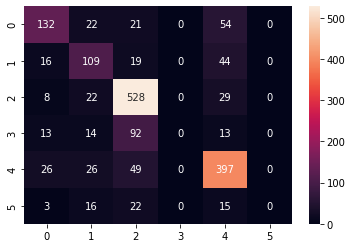

In [314]:
sns.heatmap(confmat.to('cpu').compute(),annot=True,fmt='d')

In [179]:
labels_arr = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [264]:
sentence = df_test.iloc[301]
# print(sentence.Text)
# print(sentence.Label)
test_example=torch.tensor(sentence_to_numbers('foking bastard')).unsqueeze(0).to('cuda')

In [265]:
with torch.no_grad():
    output_L=rnn_model.forward(test_example)
labels_arr[output_L.cpu().numpy().argmax()]

'anger'

In [186]:
output.shape

torch.Size([51, 6])

In [396]:
training_loss_history

[2.749933310796817,
 2.7260044860343142,
 2.7253656663000583,
 2.7098835367461045,
 2.6647939603527386,
 2.62095024223129,
 2.6068928170700865,
 2.5963211798171204,
 2.5924199677010376,
 2.587412731995185,
 2.5827957604825498,
 2.5772997366388637,
 2.573173531989257,
 2.5693880664805575,
 2.568655946503083]